In [5]:
!pip install pyspark
!pip install pyspark_dist_explore # Used for a histogram

## Importing libraries

In [6]:
from pyspark import SparkContext
# Rather than generally using the functions, I should explicitly import the ones I want.
from pyspark.sql import functions as f, SparkSession, Column
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.fpm import FPGrowth



## Create a spark session

In [7]:
# Create a spark session. All sorts of settings can be specified here.
spark = SparkSession.builder \
    .appName("arlUsingPyspark") \
    .getOrCreate()

In [8]:
df = spark.read.csv("/content/Groceries data.csv", header=True).withColumn("id", f.monotonically_increasing_id())
df_all = spark.read.csv("/content/Groceries data.csv", header=True).withColumn("id", f.monotonically_increasing_id())

In [9]:
# Show is pyspark's version of head(), although it can be slow so I do try to skip this.
df.show(5)
df_all.show(5)

+-------------+----------+----------------+----+-----+---+-----------+---+
|Member_number|      Date| itemDescription|year|month|day|day_of_week| id|
+-------------+----------+----------------+----+-----+---+-----------+---+
|         1808|2015-07-21|  tropical fruit|2015|    7| 21|          1|  0|
|         2552|2015-05-01|      whole milk|2015|    5|  1|          4|  1|
|         2300|2015-09-19|       pip fruit|2015|    9| 19|          5|  2|
|         1187|2015-12-12|other vegetables|2015|   12| 12|          5|  3|
|         3037|2015-01-02|      whole milk|2015|    1|  2|          4|  4|
+-------------+----------+----------------+----+-----+---+-----------+---+
only showing top 5 rows

+-------------+----------+----------------+----+-----+---+-----------+---+
|Member_number|      Date| itemDescription|year|month|day|day_of_week| id|
+-------------+----------+----------------+----+-----+---+-----------+---+
|         1808|2015-07-21|  tropical fruit|2015|    7| 21|          1|  0|


## printing Schema

In [10]:
# printSchema() shows the structure of the dataframe. This is important for debugging.
df.printSchema()
df_all.printSchema()

root
 |-- Member_number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- itemDescription: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- id: long (nullable = false)

root
 |-- Member_number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- itemDescription: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- id: long (nullable = false)



# How many baskets are there per customer?

In [11]:
num_baskets = df_all.groupBy("Member_number").count()
num_baskets.show(5)

+-------------+-----+
|Member_number|count|
+-------------+-----+
|         2904|   10|
|         3959|   14|
|         2294|   23|
|         4032|    4|
|         1512|   10|
+-------------+-----+
only showing top 5 rows



# The distribution of the number of baskets


(array([302., 328., 178., 371., 237., 341., 251., 538., 252., 192., 179.,
        144., 136., 109.,  69., 110.,  49.,  23.,  29.,  14.,  11.,   9.,
         13.,   4.,   1.,   4.,   0.,   3.,   0.,   1.]),
 array([ 2.        ,  3.13333333,  4.26666667,  5.4       ,  6.53333333,
         7.66666667,  8.8       ,  9.93333333, 11.06666667, 12.2       ,
        13.33333333, 14.46666667, 15.6       , 16.73333333, 17.86666667,
        19.        , 20.13333333, 21.26666667, 22.4       , 23.53333333,
        24.66666667, 25.8       , 26.93333333, 28.06666667, 29.2       ,
        30.33333333, 31.46666667, 32.6       , 33.73333333, 34.86666667,
        36.        ]),
 <BarContainer object of 30 artists>)

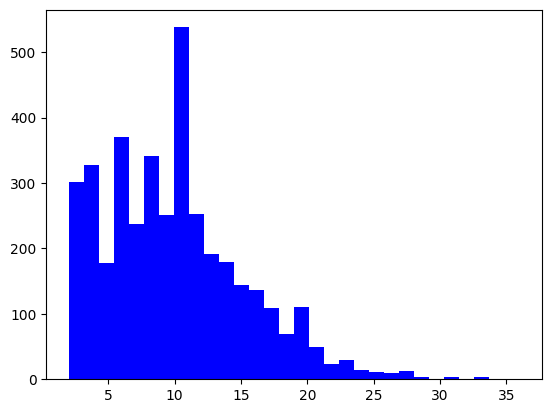

In [12]:
fig, ax = plt.subplots()

hist(ax, num_baskets.select('count'), bins = 30, color=['blue'])

# Run PySpark's implementation of FPGrowth

In [13]:
df_basket = df.select("id", f.array([df[c] for c in df.columns[:11]]).alias("basket"))
df_basket.printSchema()
# False tells show() to not truncate the columns when printing.
df_basket.show(3, False)

root
 |-- id: long (nullable = false)
 |-- basket: array (nullable = false)
 |    |-- element: string (containsNull = true)

+---+-----------------------------------------------------+
|id |basket                                               |
+---+-----------------------------------------------------+
|0  |[1808, 2015-07-21, tropical fruit, 2015, 7, 21, 1, 0]|
|1  |[2552, 2015-05-01, whole milk, 2015, 5, 1, 4, 1]     |
|2  |[2300, 2015-09-19, pip fruit, 2015, 9, 19, 5, 2]     |
+---+-----------------------------------------------------+
only showing top 3 rows



### There should not be any nulls in the array. Remove using array_except()

In [14]:
df_aggregated = df_basket.select("id", f.array_except("basket", f.array(f.lit(None))).alias("basket"))
df_aggregated.show(3, False)

+---+-----------------------------------------------------+
|id |basket                                               |
+---+-----------------------------------------------------+
|0  |[1808, 2015-07-21, tropical fruit, 2015, 7, 21, 1, 0]|
|1  |[2552, 2015-05-01, whole milk, 2015, 5, 1, 4]        |
|2  |[2300, 2015-09-19, pip fruit, 2015, 9, 19, 5, 2]     |
+---+-----------------------------------------------------+
only showing top 3 rows



## Hyperparameters

In [15]:
# Run FPGrowth and fit the model.
fp = FPGrowth(minSupport=0.001, minConfidence=0.001, itemsCol='basket', predictionCol='prediction')
model = fp.fit(df_aggregated)

In [16]:
# View a subset of the frequent itemset.
model.freqItemsets.show(10, False)

+-----------------------------+----+
|items                        |freq|
+-----------------------------+----+
|[2015-11-27]                 |82  |
|[2015-11-27, 4]              |82  |
|[2015-11-27, 4, 2015]        |82  |
|[2015-11-27, 27]             |82  |
|[2015-11-27, 27, 4]          |82  |
|[2015-11-27, 27, 4, 2015]    |82  |
|[2015-11-27, 27, 11]         |82  |
|[2015-11-27, 27, 11, 4]      |82  |
|[2015-11-27, 27, 11, 4, 2015]|82  |
|[2015-11-27, 27, 11, 2015]   |82  |
+-----------------------------+----+
only showing top 10 rows



In [17]:
# Use filter to view just the association rules with the highest confidence.
model.associationRules.filter(model.associationRules.confidence>0.15).show(20, False)

+--------------------------+----------+-------------------+------------------+---------------------+
|antecedent                |consequent|confidence         |lift              |support              |
+--------------------------+----------+-------------------+------------------+---------------------+
|[2014-02-09, 2]           |[9]       |1.0                |9.379385434309219 |0.0016251773507029537|
|[2014-02-09, 2]           |[6]       |1.0                |4.173215631391969 |0.0016251773507029537|
|[2014-02-09, 2]           |[2014]    |1.0                |2.120507630873585 |0.0016251773507029537|
|[2014-11-21, 21, 11, 2014]|[4]       |1.0                |4.162461075915387 |0.0012124338965561717|
|[2014-10-18, 18, 5, 2014] |[10]      |1.0                |8.7882566311494   |0.001367212691861215 |
|[2015-10-15]              |[3]       |1.0                |4.065547981122181 |0.0014446020895137366|
|[2015-10-15]              |[15]      |1.0                |31.1115569823435  |0.00144460208

## Let's create a prediction based on the generated association rules

In [18]:
# Create a PySpark dataframe
columns = ['basket']
new_data = [(['ham', 'yogurt', 'light bulbs'],), (['jam', 'cocoa drinks', 'pet care'],)]
rdd = spark.sparkContext.parallelize(new_data)
new_df = rdd.toDF(columns)
new_df.printSchema()
new_df.show(2,False)

root
 |-- basket: array (nullable = true)
 |    |-- element: string (containsNull = true)

+-----------------------------+
|basket                       |
+-----------------------------+
|[ham, yogurt, light bulbs]   |
|[jam, cocoa drinks, pet care]|
+-----------------------------+



# Predict!

In [19]:
model.transform(new_df).show(5, False)

+-----------------------------+----------------------------------------------------------------------------------------------------------+
|basket                       |prediction                                                                                                |
+-----------------------------+----------------------------------------------------------------------------------------------------------+
|[ham, yogurt, light bulbs]   |[3, 6, 4, 2, 2014, 1, 5, 2015, 25, 24, 19, 29, 23, 18, 16, 22, 14, 0, 7, 21, 9, 12, 13, 11, 28, 8, 10, 26]|
|[jam, cocoa drinks, pet care]|[2014, 2015]                                                                                              |
+-----------------------------+----------------------------------------------------------------------------------------------------------+

